# Comprehensive Data Analysis - Test Dataset

This notebook provides a thorough exploratory data analysis of the test.csv dataset, focusing on:
- Data structure and basic information
- Missing values analysis
- Duplicate detection
- Statistical summaries
- Data visualization
- Column-wise analysis
- Understanding the prediction task structure

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

# Create graphs directory if it doesn't exist
graphs_dir = 'graphs'
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)
    print(f"Created directory: {graphs_dir}")
else:
    print(f"Directory {graphs_dir} already exists")

# Create test graphs directory if it doesn't exist
test_graphs_dir = f'{graphs_dir}/test_graphs_dir'
if not os.path.exists(test_graphs_dir):
    os.makedirs(test_graphs_dir)
    print(f"Created directory: {test_graphs_dir}")
else:
    print(f"Directory {test_graphs_dir} already exists")

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

Directory graphs already exists
Created directory: graphs/test_graphs_dir


## 1. Data Loading and Initial Inspection

In [30]:
# Load the test dataset
test_df = pd.read_csv('../data/test.csv')

print("=== TEST DATASET ===")
print(f"Shape: {test_df.shape}")
print(f"Columns: {list(test_df.columns)}")
print("\nColumn descriptions:")
print("- row_id: Unique identifier for each prediction row")
print("- item_id: Location identifier (Location4)")
print("- anchor_time: The reference time point")
print("- Time: The target prediction time (anchor_time + 24h)")
print("- anchor_*: Weather covariates at the anchor time")

=== TEST DATASET ===
Shape: (60, 12)
Columns: ['row_id', 'item_id', 'anchor_time', 'Time', 'anchor_temperature_2m', 'anchor_relativehumidity_2m', 'anchor_dewpoint_2m', 'anchor_windspeed_10m', 'anchor_windspeed_100m', 'anchor_winddirection_10m', 'anchor_winddirection_100m', 'anchor_windgusts_10m']

Column descriptions:
- row_id: Unique identifier for each prediction row
- item_id: Location identifier (Location4)
- anchor_time: The reference time point
- Time: The target prediction time (anchor_time + 24h)
- anchor_*: Weather covariates at the anchor time


In [31]:
# Focus on test dataset for detailed analysis
dataset_df = test_df.copy()

# Analyze dataset
dataset_head = dataset_df.head().to_string()
dataset_tails = dataset_df.tail().to_string()
dataset_shape = dataset_df.shape
rows, cols = dataset_shape

# Inspect and log head, tail, dimensions and shape
print(f"Dataset head:\n{dataset_head}")
print(f"\nDataset tail:\n{dataset_tails}")
print(f"\nDataset shape: {dataset_shape}")
print(f"Dataset has {cols} columns and {rows} rows")

Dataset head:
                       row_id    item_id          anchor_time                 Time  anchor_temperature_2m  anchor_relativehumidity_2m  anchor_dewpoint_2m  anchor_windspeed_10m  anchor_windspeed_100m  anchor_winddirection_10m  anchor_winddirection_100m  anchor_windgusts_10m
0  Location4_202111011200_T24  Location4  2021-11-01 12:00:00  2021-11-02 12:00:00                   43.3                          40                20.4                  7.13                   9.75                       276                        276                  13.2
1  Location4_202111021200_T24  Location4  2021-11-02 12:00:00  2021-11-03 12:00:00                   40.2                          46                20.9                  5.91                   7.74                       298                        299                  11.2
2  Location4_202111031200_T24  Location4  2021-11-03 12:00:00  2021-11-04 12:00:00                   39.0                          43                18.3           

In [32]:
# Ensure all columns are shown when printing
pd.set_option('display.max_columns', None)

# Summary statistics of numeric columns
numeric_cols = dataset_df.select_dtypes(include=[np.number]).columns
print("Summary statistics:\n", dataset_df[numeric_cols].describe())
print("")
print("")

# Check for missing data
missing_values = dataset_df.isnull().sum()
print(f"Missing values per column:\n{missing_values}")
print("")
print("")

# Check for duplicate rows
duplicate_rows = dataset_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Summary statistics:
        anchor_temperature_2m  anchor_relativehumidity_2m  anchor_dewpoint_2m  \
count              60.000000                   60.000000           60.000000   
mean               37.710000                   55.966667           22.500000   
std                 9.909894                   16.660078           12.653183   
min                15.800000                   27.000000           -7.900000   
25%                31.925000                   46.000000           16.375000   
50%                37.100000                   51.500000           21.600000   
75%                43.850000                   66.250000           29.000000   
max                61.200000                   99.000000           57.000000   

       anchor_windspeed_10m  anchor_windspeed_100m  anchor_winddirection_10m  \
count             60.000000              60.000000                 60.000000   
mean               5.194667               7.348833                220.133333   
std               

## 2. Data Type Analysis and Time Column Processing

In [33]:
# Check data types
print("Data types:")
print(dataset_df.dtypes)
print("\n")

# Convert Time columns to datetime
dataset_df['anchor_time'] = pd.to_datetime(dataset_df['anchor_time'])
dataset_df['Time'] = pd.to_datetime(dataset_df['Time'])
print(f"Anchor time range: {dataset_df['anchor_time'].min()} to {dataset_df['anchor_time'].max()}")
print(f"Target time range: {dataset_df['Time'].min()} to {dataset_df['Time'].max()}")

# Verify the 24-hour prediction window
time_diff = (dataset_df['Time'] - dataset_df['anchor_time']).dt.total_seconds() / 3600
print(f"\nTime difference between anchor and target (hours): {time_diff.unique()}")

# Check unique locations
print(f"\nUnique locations: {dataset_df['item_id'].unique()}")
print(f"Number of unique locations: {dataset_df['item_id'].nunique()}")

Data types:
row_id                         object
item_id                        object
anchor_time                    object
Time                           object
anchor_temperature_2m         float64
anchor_relativehumidity_2m      int64
anchor_dewpoint_2m            float64
anchor_windspeed_10m          float64
anchor_windspeed_100m         float64
anchor_winddirection_10m        int64
anchor_winddirection_100m       int64
anchor_windgusts_10m          float64
dtype: object


Anchor time range: 2021-11-01 12:00:00 to 2021-12-30 12:00:00
Target time range: 2021-11-02 12:00:00 to 2021-12-31 12:00:00

Time difference between anchor and target (hours): [24.]

Unique locations: ['Location4']
Number of unique locations: 1


## 3. Row ID Analysis

In [34]:
# Analyze row_id structure
print("Sample row_id values:")
print(dataset_df['row_id'].head(10).tolist())
print("\nRow ID structure analysis:")
print("Format appears to be: Location4_YYYYMMDDHHMM_T24")
print("Where:")
print("- Location4: The location identifier")
print("- YYYYMMDDHHMM: Timestamp in format (anchor_time)")
print("- T24: Indicates 24-hour ahead prediction")

# Extract timestamp from row_id and verify consistency
def extract_timestamp_from_row_id(row_id):
    parts = row_id.split('_')
    if len(parts) >= 2:
        timestamp_str = parts[1]
        return pd.to_datetime(timestamp_str, format='%Y%m%d%H%M')
    return None

dataset_df['extracted_time'] = dataset_df['row_id'].apply(extract_timestamp_from_row_id)
time_consistency = (dataset_df['extracted_time'] == dataset_df['anchor_time']).all()
print(f"\nTime consistency between row_id and anchor_time: {time_consistency}")

Sample row_id values:
['Location4_202111011200_T24', 'Location4_202111021200_T24', 'Location4_202111031200_T24', 'Location4_202111041200_T24', 'Location4_202111051200_T24', 'Location4_202111061200_T24', 'Location4_202111071200_T24', 'Location4_202111081200_T24', 'Location4_202111091200_T24', 'Location4_202111101200_T24']

Row ID structure analysis:
Format appears to be: Location4_YYYYMMDDHHMM_T24
Where:
- Location4: The location identifier
- YYYYMMDDHHMM: Timestamp in format (anchor_time)
- T24: Indicates 24-hour ahead prediction

Time consistency between row_id and anchor_time: True


## 4. Weather Variables Analysis

In [35]:
# Get weather columns (anchor_* columns)
weather_columns = [col for col in dataset_df.columns if col.startswith('anchor_') and dataset_df[col].dtype in ['int64', 'float64']]
print(f"Weather variables: {weather_columns}")
print(f"Number of weather variables: {len(weather_columns)}")

# Create a mapping of weather variables to their descriptions
weather_descriptions = {
    'anchor_temperature_2m': 'Temperature at 2m height (°F)',
    'anchor_relativehumidity_2m': 'Relative humidity at 2m height (%)',
    'anchor_dewpoint_2m': 'Dew point at 2m height (°F)',
    'anchor_windspeed_10m': 'Wind speed at 10m height (mph)',
    'anchor_windspeed_100m': 'Wind speed at 100m height (mph)',
    'anchor_winddirection_10m': 'Wind direction at 10m height (degrees)',
    'anchor_winddirection_100m': 'Wind direction at 100m height (degrees)',
    'anchor_windgusts_10m': 'Wind gusts at 10m height (mph)'
}

print("\nWeather variable descriptions:")
for var, desc in weather_descriptions.items():
    print(f"- {var}: {desc}")

Weather variables: ['anchor_temperature_2m', 'anchor_relativehumidity_2m', 'anchor_dewpoint_2m', 'anchor_windspeed_10m', 'anchor_windspeed_100m', 'anchor_winddirection_10m', 'anchor_winddirection_100m', 'anchor_windgusts_10m']
Number of weather variables: 8

Weather variable descriptions:
- anchor_temperature_2m: Temperature at 2m height (°F)
- anchor_relativehumidity_2m: Relative humidity at 2m height (%)
- anchor_dewpoint_2m: Dew point at 2m height (°F)
- anchor_windspeed_10m: Wind speed at 10m height (mph)
- anchor_windspeed_100m: Wind speed at 100m height (mph)
- anchor_winddirection_10m: Wind direction at 10m height (degrees)
- anchor_winddirection_100m: Wind direction at 100m height (degrees)
- anchor_windgusts_10m: Wind gusts at 10m height (mph)


## 5. Time-Based Visualizations

Creating time series plots for 8 weather variables


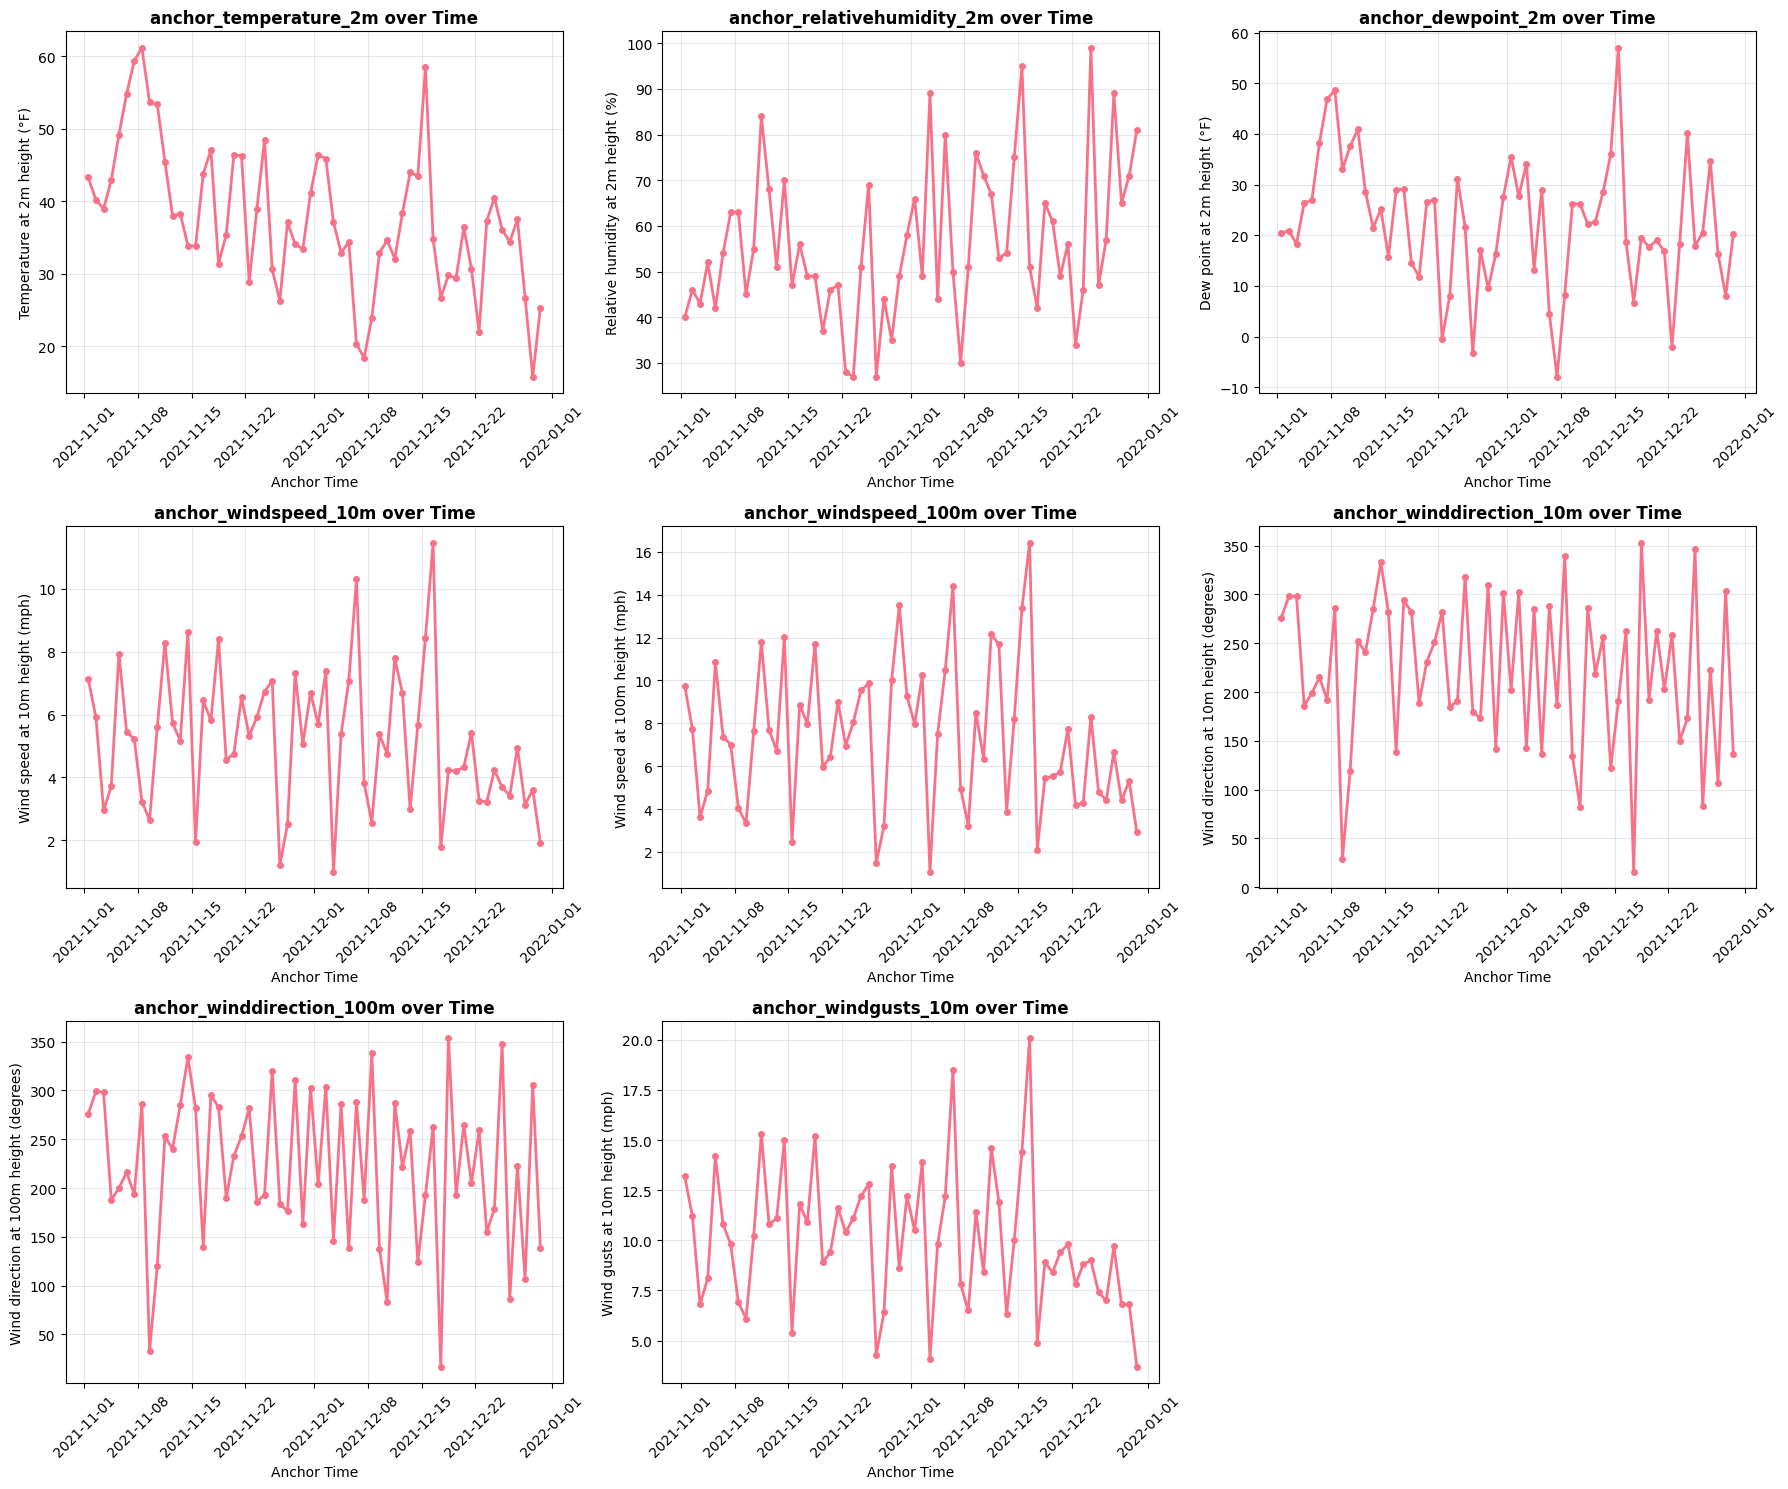

Saved: graphs/test_graphs_dir/weather_variables_timeseries.png


In [36]:
# Create time series plots for all weather variables
print(f"Creating time series plots for {len(weather_columns)} weather variables")

# Create subplot grid - use 3x3 to ensure we have enough subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(weather_columns):
    if i < len(axes):  # Safety check
        axes[i].plot(dataset_df['anchor_time'], dataset_df[col], marker='o', linewidth=2, markersize=4)
        axes[i].set_title(f'{col} over Time', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Anchor Time')
        axes[i].set_ylabel(weather_descriptions.get(col, col))
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for i in range(len(weather_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig(f'{test_graphs_dir}/weather_variables_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {test_graphs_dir}/weather_variables_timeseries.png")

## 6. Distribution Analysis

Creating distribution plots for 8 weather variables


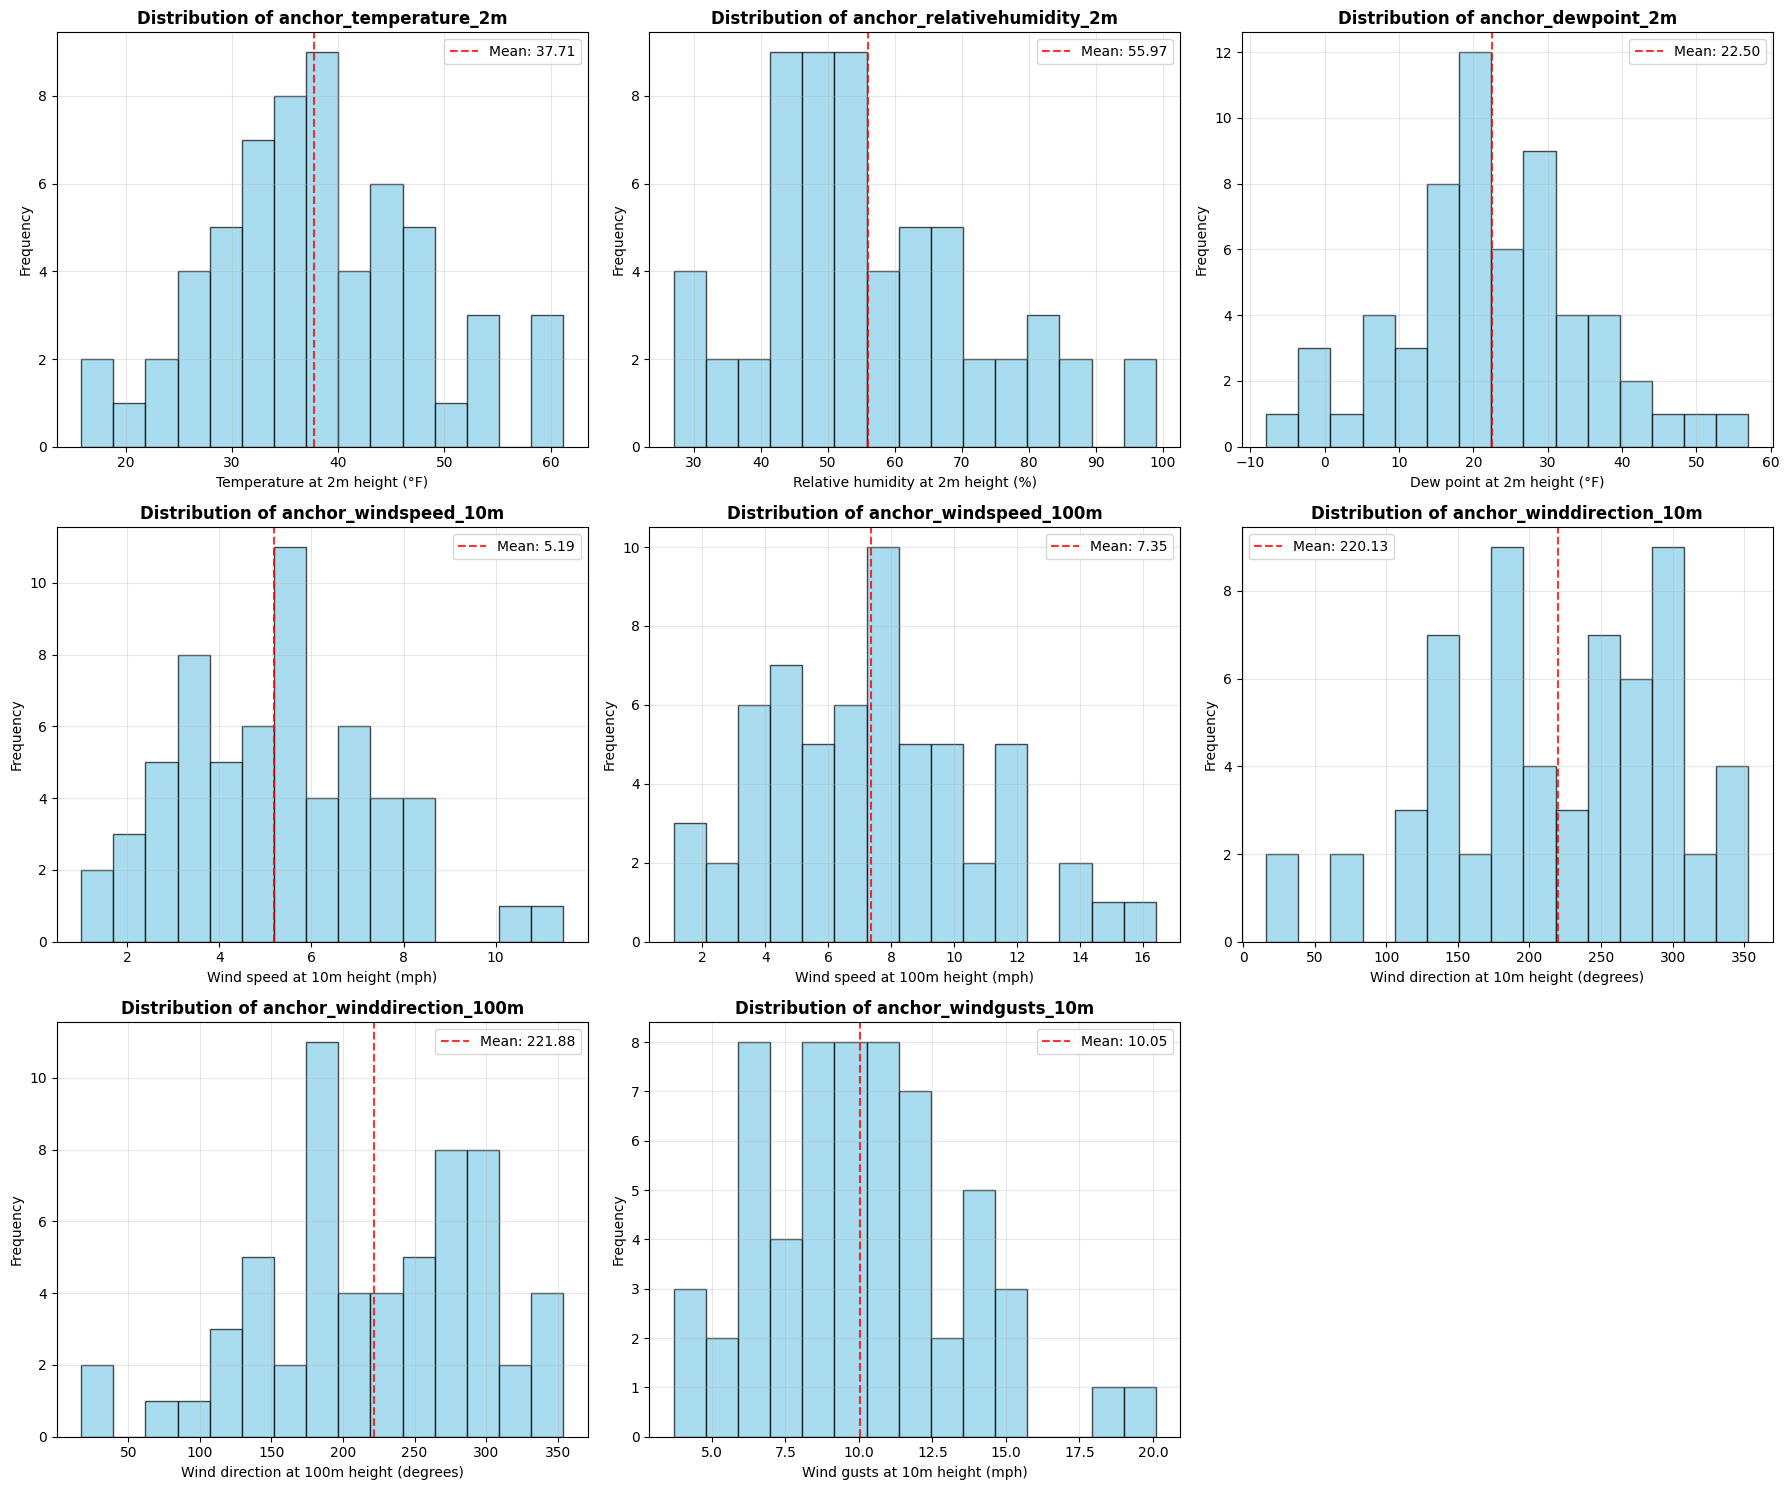

Saved: graphs/test_graphs_dir/weather_variables_distributions.png


In [37]:
# Create distribution plots for all weather variables
print(f"Creating distribution plots for {len(weather_columns)} weather variables")

# Create subplot grid - use 3x3 to ensure we have enough subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(weather_columns):
    if i < len(axes):  # Safety check
        # Histogram
        axes[i].hist(dataset_df[col], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(weather_descriptions.get(col, col))
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics text
        mean_val = dataset_df[col].mean()
        std_val = dataset_df[col].std()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
        axes[i].legend()

# Hide unused subplots
for i in range(len(weather_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig(f'{test_graphs_dir}/weather_variables_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {test_graphs_dir}/weather_variables_distributions.png")

## 7. Correlation Analysis

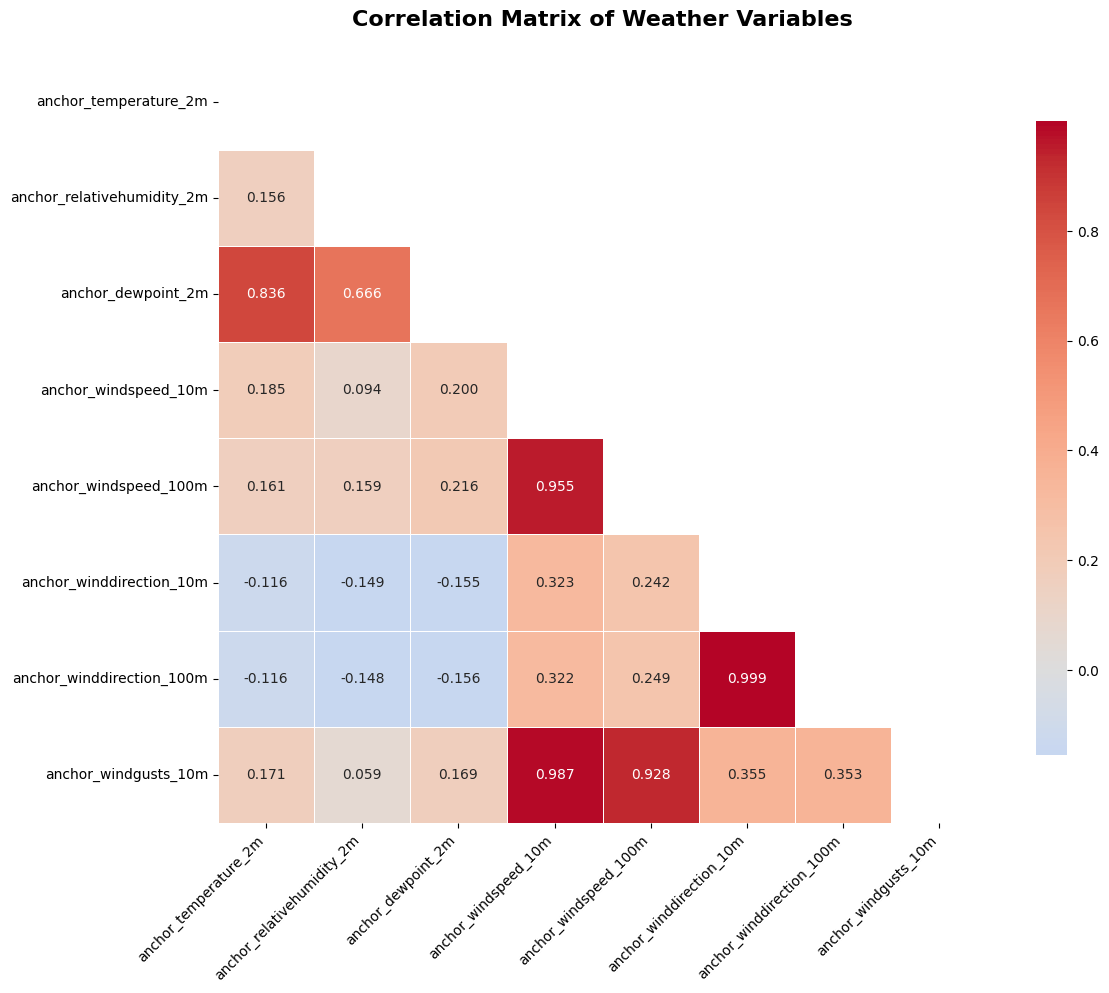

Saved: graphs/test_graphs_dir/weather_correlation_matrix.png

High correlations (|r| > 0.7):
anchor_temperature_2m vs anchor_dewpoint_2m: 0.836
anchor_windspeed_10m vs anchor_windspeed_100m: 0.955
anchor_windspeed_10m vs anchor_windgusts_10m: 0.987
anchor_windspeed_100m vs anchor_windgusts_10m: 0.928
anchor_winddirection_10m vs anchor_winddirection_100m: 0.999


In [38]:
# Calculate correlation matrix for weather variables
weather_data = dataset_df[weather_columns]
correlation_matrix = weather_data.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.3f')
plt.title('Correlation Matrix of Weather Variables', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{test_graphs_dir}/weather_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {test_graphs_dir}/weather_correlation_matrix.png")

# Print high correlations
print("\nHigh correlations (|r| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: {corr_val:.3f}")

## 8. Wind Analysis

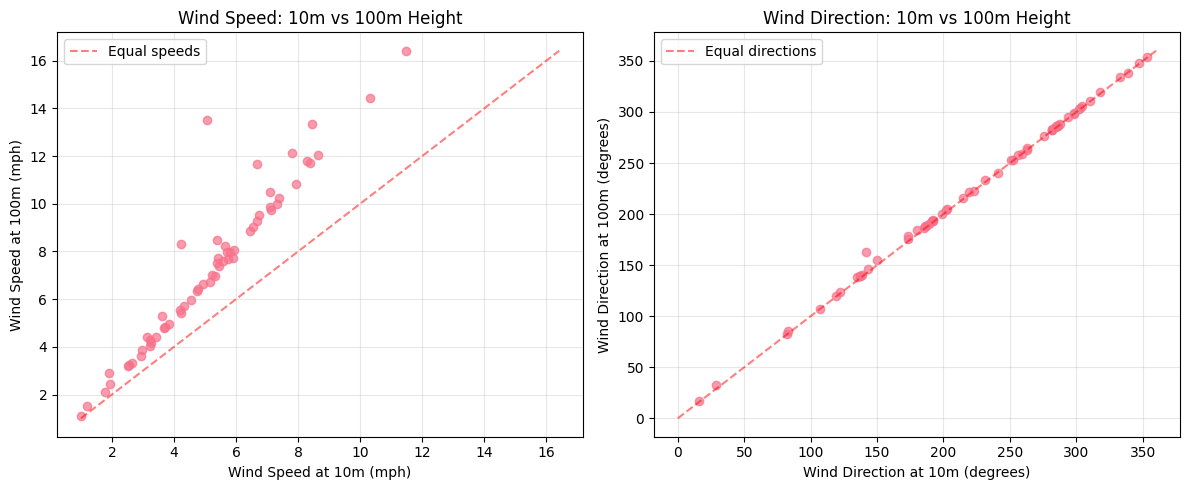

Saved: graphs/test_graphs_dir/wind_analysis.png


In [39]:
# Wind speed comparison (10m vs 100m)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(dataset_df['anchor_windspeed_10m'], dataset_df['anchor_windspeed_100m'], alpha=0.7)
plt.xlabel('Wind Speed at 10m (mph)')
plt.ylabel('Wind Speed at 100m (mph)')
plt.title('Wind Speed: 10m vs 100m Height')
plt.grid(True, alpha=0.3)

# Add diagonal line for reference
min_val = min(dataset_df['anchor_windspeed_10m'].min(), dataset_df['anchor_windspeed_100m'].min())
max_val = max(dataset_df['anchor_windspeed_10m'].max(), dataset_df['anchor_windspeed_100m'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Equal speeds')
plt.legend()

# Wind direction comparison (10m vs 100m)
plt.subplot(1, 2, 2)
plt.scatter(dataset_df['anchor_winddirection_10m'], dataset_df['anchor_winddirection_100m'], alpha=0.7)
plt.xlabel('Wind Direction at 10m (degrees)')
plt.ylabel('Wind Direction at 100m (degrees)')
plt.title('Wind Direction: 10m vs 100m Height')
plt.grid(True, alpha=0.3)

# Add diagonal line for reference
plt.plot([0, 360], [0, 360], 'r--', alpha=0.5, label='Equal directions')
plt.legend()

plt.tight_layout()
plt.savefig(f'{test_graphs_dir}/wind_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {test_graphs_dir}/wind_analysis.png")

## 9. Temporal Patterns

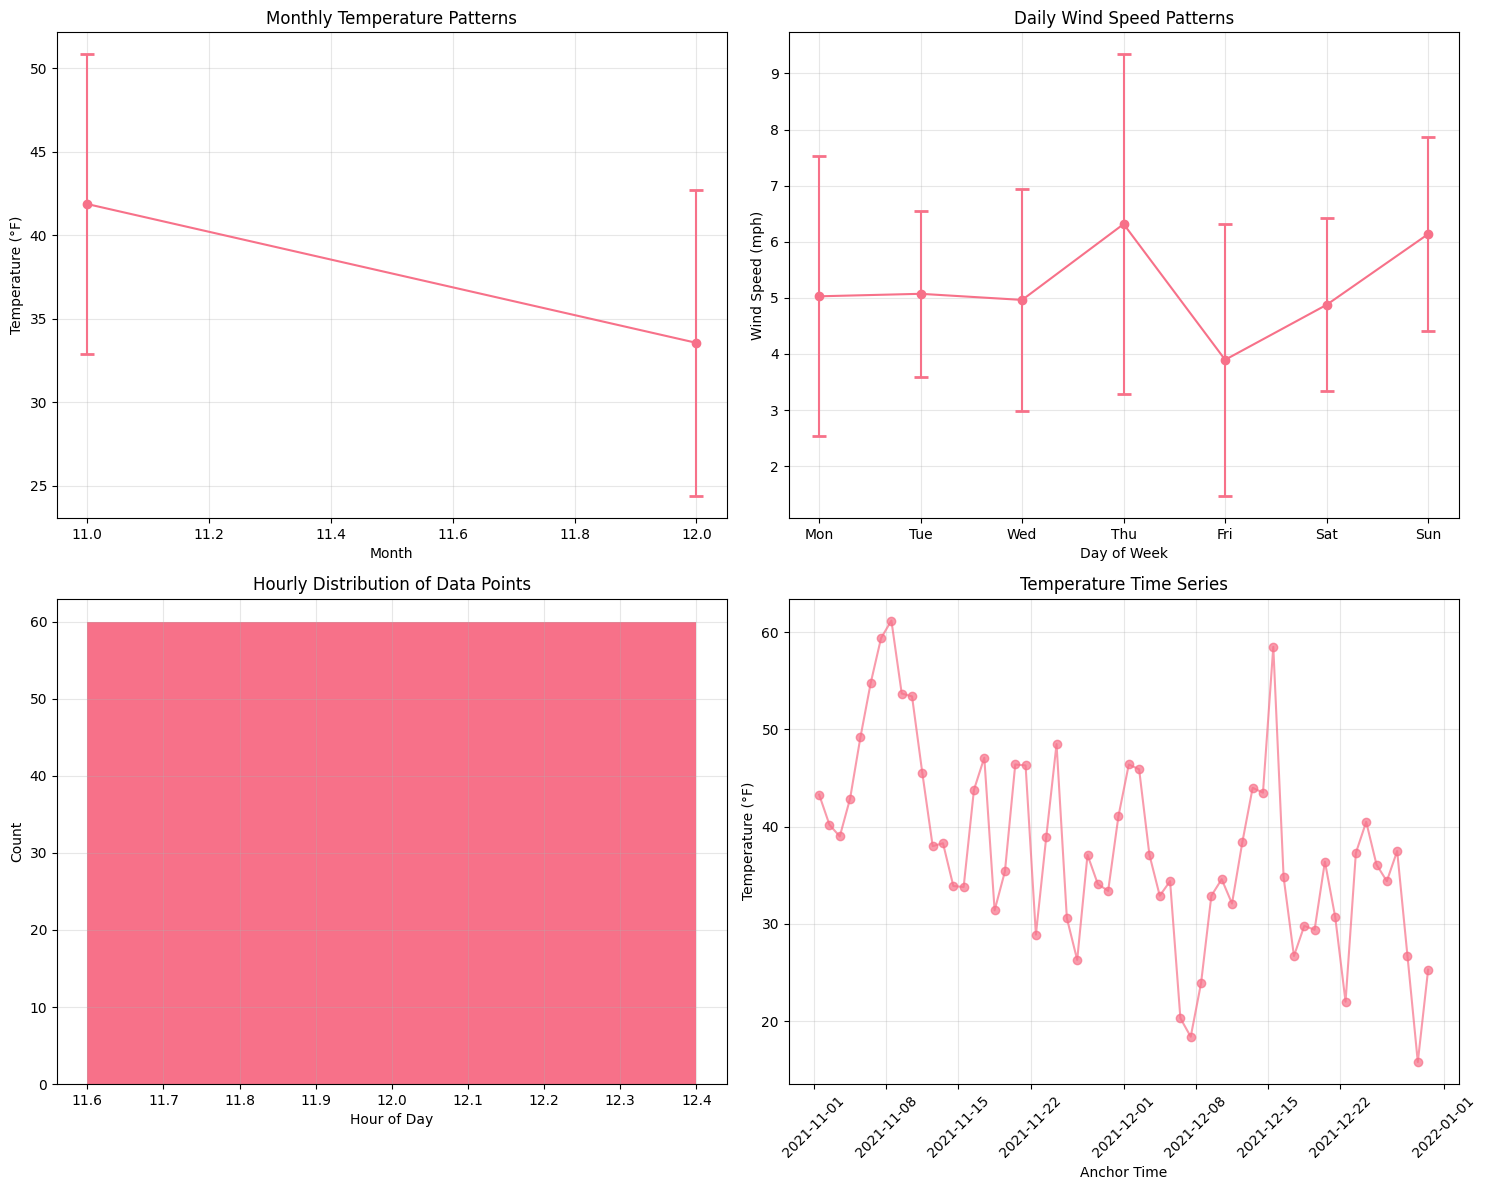

Saved: graphs/test_graphs_dir/temporal_patterns.png


In [40]:
# Extract temporal features
dataset_df['month'] = dataset_df['anchor_time'].dt.month
dataset_df['day_of_week'] = dataset_df['anchor_time'].dt.dayofweek
dataset_df['hour'] = dataset_df['anchor_time'].dt.hour

# Create temporal analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Monthly patterns for temperature
monthly_temp = dataset_df.groupby('month')['anchor_temperature_2m'].agg(['mean', 'std']).reset_index()
axes[0, 0].errorbar(monthly_temp['month'], monthly_temp['mean'], yerr=monthly_temp['std'], 
                   marker='o', capsize=5, capthick=2)
axes[0, 0].set_title('Monthly Temperature Patterns')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°F)')
axes[0, 0].grid(True, alpha=0.3)

# Daily patterns for wind speed
daily_wind = dataset_df.groupby('day_of_week')['anchor_windspeed_10m'].agg(['mean', 'std']).reset_index()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].errorbar(daily_wind['day_of_week'], daily_wind['mean'], yerr=daily_wind['std'], 
                   marker='o', capsize=5, capthick=2)
axes[0, 1].set_title('Daily Wind Speed Patterns')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Wind Speed (mph)')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].grid(True, alpha=0.3)

# Hourly patterns (all data is at 12:00, so this will be uniform)
hourly_temp = dataset_df.groupby('hour')['anchor_temperature_2m'].agg(['mean', 'count']).reset_index()
axes[1, 0].bar(hourly_temp['hour'], hourly_temp['count'])
axes[1, 0].set_title('Hourly Distribution of Data Points')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(True, alpha=0.3)

# Time series of all anchor times
axes[1, 1].plot(dataset_df['anchor_time'], dataset_df['anchor_temperature_2m'], 'o-', alpha=0.7)
axes[1, 1].set_title('Temperature Time Series')
axes[1, 1].set_xlabel('Anchor Time')
axes[1, 1].set_ylabel('Temperature (°F)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{test_graphs_dir}/temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {test_graphs_dir}/temporal_patterns.png")

## 10. Statistical Summary and Insights

In [41]:
# Comprehensive statistical summary
# Force correct weather_columns definition to avoid datetime errors
weather_columns = [col for col in dataset_df.columns if col.startswith('anchor_') and dataset_df[col].dtype in ['int64', 'float64']]
print("=== TEST DATASET STATISTICAL SUMMARY ===")
print(f"Total number of predictions required: {len(dataset_df)}")
print(f"Prediction period: {dataset_df['anchor_time'].min().strftime('%Y-%m-%d')} to {dataset_df['anchor_time'].max().strftime('%Y-%m-%d')}")
print(f"All predictions are for Location: {dataset_df['item_id'].unique()[0]}")
print(f"Prediction horizon: 24 hours ahead")
print(f"All anchor times are at: {dataset_df['hour'].unique()[0]}:00 (noon)")

print("\n=== WEATHER VARIABLE RANGES ===")
# Filter to only numeric weather columns to avoid datetime formatting errors
numeric_weather_cols = [col for col in weather_columns if dataset_df[col].dtype in ['int64', 'float64']]
print(f"Analyzing {len(numeric_weather_cols)} numeric weather variables")
for col in numeric_weather_cols:
    min_val = dataset_df[col].min()
    max_val = dataset_df[col].max()
    mean_val = dataset_df[col].mean()
    std_val = dataset_df[col].std()
    print(f"{col}:")
    print(f"  Range: {min_val:.2f} to {max_val:.2f}")
    print(f"  Mean ± Std: {mean_val:.2f} ± {std_val:.2f}")

print("\n=== DATA QUALITY ASSESSMENT ===")
print(f"Missing values: {dataset_df.isnull().sum().sum()}")
print(f"Duplicate rows: {dataset_df.duplicated().sum()}")
print(f"Data completeness: {(1 - dataset_df.isnull().sum().sum() / (len(dataset_df) * len(dataset_df.columns))) * 100:.1f}%")

print("\n=== KEY INSIGHTS ===")
print("1. This is a next-day power prediction task for Location4")
print("2. All predictions are made at noon (12:00) for the next day at noon")
print("3. Weather covariates are provided at the anchor time only")
print("4. The dataset covers approximately 2 months of predictions")
print("5. No missing values - clean dataset ready for modeling")
print("6. Wind speeds are consistently higher at 100m than at 10m height")
print("7. Wind directions at different heights are highly correlated")

=== TEST DATASET STATISTICAL SUMMARY ===
Total number of predictions required: 60
Prediction period: 2021-11-01 to 2021-12-30
All predictions are for Location: Location4
Prediction horizon: 24 hours ahead
All anchor times are at: 12:00 (noon)

=== WEATHER VARIABLE RANGES ===
Analyzing 8 numeric weather variables
anchor_temperature_2m:
  Range: 15.80 to 61.20
  Mean ± Std: 37.71 ± 9.91
anchor_relativehumidity_2m:
  Range: 27.00 to 99.00
  Mean ± Std: 55.97 ± 16.66
anchor_dewpoint_2m:
  Range: -7.90 to 57.00
  Mean ± Std: 22.50 ± 12.65
anchor_windspeed_10m:
  Range: 1.00 to 11.47
  Mean ± Std: 5.19 ± 2.20
anchor_windspeed_100m:
  Range: 1.08 to 16.42
  Mean ± Std: 7.35 ± 3.40
anchor_winddirection_10m:
  Range: 16.00 to 353.00
  Mean ± Std: 220.13 ± 79.19
anchor_winddirection_100m:
  Range: 17.00 to 354.00
  Mean ± Std: 221.88 ± 78.32
anchor_windgusts_10m:
  Range: 3.70 to 20.10
  Mean ± Std: 10.05 ± 3.40

=== DATA QUALITY ASSESSMENT ===
Missing values: 0
Duplicate rows: 0
Data completene

## 11. Comparison with Training Data Context

In [42]:
# Load training data for comparison
try:
    train_df = pd.read_csv('../data/train.csv')
    train_df['Time'] = pd.to_datetime(train_df['Time'])
    
    print("=== COMPARISON WITH TRAINING DATA ===")
    print(f"Training data period: {train_df['Time'].min().strftime('%Y-%m-%d')} to {train_df['Time'].max().strftime('%Y-%m-%d')}")
    print(f"Test data period: {dataset_df['anchor_time'].min().strftime('%Y-%m-%d')} to {dataset_df['anchor_time'].max().strftime('%Y-%m-%d')}")
    
    # Check if test period follows training period
    train_end = train_df['Time'].max()
    test_start = dataset_df['anchor_time'].min()
    
    print(f"\nTime gap between training end and test start: {(test_start - train_end).days} days")
    
    # Location4 data in training set
    loc4_train = train_df[train_df['item_id'] == 'Location4']
    print(f"\nLocation4 in training data:")
    print(f"  Records: {len(loc4_train)}")
    print(f"  Period: {loc4_train['Time'].min().strftime('%Y-%m-%d')} to {loc4_train['Time'].max().strftime('%Y-%m-%d')}")
    print(f"  Power range: {loc4_train['Power'].min():.4f} to {loc4_train['Power'].max():.4f}")
    
except FileNotFoundError:
    print("Training data not found for comparison")

=== COMPARISON WITH TRAINING DATA ===
Training data period: 2020-01-01 to 2020-12-31
Test data period: 2021-11-01 to 2021-12-30

Time gap between training end and test start: 305 days

Location4 in training data:
  Records: 365
  Period: 2020-01-01 to 2020-12-31
  Power range: 0.0000 to 0.9755


## 12. Feature Engineering Suggestions

In [43]:
print("=== FEATURE ENGINEERING SUGGESTIONS ===")
print("\nBased on the test data analysis, consider these features:")
print("\n1. TEMPORAL FEATURES:")
print("   - Month, day of year, day of week")
print("   - Season indicators")
print("   - Days since/until solstices and equinoxes")

print("\n2. WEATHER INTERACTIONS:")
print("   - Wind power proxy: windspeed^3 (cube of wind speed)")
print("   - Temperature-humidity interactions")
print("   - Wind shear: difference between 100m and 10m speeds")
print("   - Wind direction consistency between heights")

print("\n3. LAGGED FEATURES (from training data):")
print("   - Previous day's power output")
print("   - Rolling averages of weather variables (3, 7, 30 days)")
print("   - Weather change rates (day-to-day differences)")

print("\n4. DERIVED WEATHER FEATURES:")
print("   - Heat index (temperature + humidity)")
print("   - Wind chill factor")
print("   - Atmospheric pressure proxy (temperature + humidity)")
print("   - Wind direction in radians (sin/cos transformation)")

print("\n5. POWER-SPECIFIC FEATURES:")
print("   - Optimal wind speed ranges for power generation")
print("   - Temperature efficiency factors")
print("   - Seasonal power generation patterns")

# Demonstrate some feature engineering
print("\n=== EXAMPLE FEATURE ENGINEERING ===")
dataset_df['wind_power_proxy'] = dataset_df['anchor_windspeed_100m'] ** 3
dataset_df['wind_shear'] = dataset_df['anchor_windspeed_100m'] - dataset_df['anchor_windspeed_10m']
dataset_df['temp_humidity_interaction'] = dataset_df['anchor_temperature_2m'] * dataset_df['anchor_relativehumidity_2m']
dataset_df['wind_direction_consistency'] = abs(dataset_df['anchor_winddirection_100m'] - dataset_df['anchor_winddirection_10m'])

print("Created example features:")
print(f"- wind_power_proxy: mean = {dataset_df['wind_power_proxy'].mean():.2f}")
print(f"- wind_shear: mean = {dataset_df['wind_shear'].mean():.2f}")
print(f"- temp_humidity_interaction: mean = {dataset_df['temp_humidity_interaction'].mean():.2f}")
print(f"- wind_direction_consistency: mean = {dataset_df['wind_direction_consistency'].mean():.2f}")

=== FEATURE ENGINEERING SUGGESTIONS ===

Based on the test data analysis, consider these features:

1. TEMPORAL FEATURES:
   - Month, day of year, day of week
   - Season indicators
   - Days since/until solstices and equinoxes

2. WEATHER INTERACTIONS:
   - Wind power proxy: windspeed^3 (cube of wind speed)
   - Temperature-humidity interactions
   - Wind shear: difference between 100m and 10m speeds
   - Wind direction consistency between heights

3. LAGGED FEATURES (from training data):
   - Previous day's power output
   - Rolling averages of weather variables (3, 7, 30 days)
   - Weather change rates (day-to-day differences)

4. DERIVED WEATHER FEATURES:
   - Heat index (temperature + humidity)
   - Wind chill factor
   - Atmospheric pressure proxy (temperature + humidity)
   - Wind direction in radians (sin/cos transformation)

5. POWER-SPECIFIC FEATURES:
   - Optimal wind speed ranges for power generation
   - Temperature efficiency factors
   - Seasonal power generation pattern